In [3]:
#importing all the necessary libraries. Some of the libraries might not be required.

In [4]:
import itertools

import numpy as np
from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os


from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from lightgbm import LGBMRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import STL

In [5]:
#Uploading the sales data
# Link to the dataset: https://herts365-my.sharepoint.com/:x:/r/personal/sm22acy_herts_ac_uk/Documents/MSc_Project_21078559/sales_train_evaluation_data_for_Exploratory_Data_Analysis.csv?d=wd237a3fe8acb461d9028d0c75330e7b3&csf=1&web=1&e=Ksqeoy

In [6]:
sales_data = pd.read_csv('sales_train_evaluation.csv')

sales_data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [7]:
# the reduce_mem_usage function which iterates through each feature and 
# checks which features fall into which integer and floating data type bands.
# for example, if feature x requires just int 16 but it has been assigned int 32. 
# Then the function, converts the int 32 into int 16 thus saving memory and computational resources 

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type =='category': 
            df[col] = df[col].astype('category').cat.as_ordered()
            #faced an error where you cannot calculate the max and min value that an category can take
        
        elif col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


sales_data = reduce_mem_usage(sales_data)

Memory usage of dataframe is 452.91 MB
Memory usage after optimization is: 96.13 MB
Decreased by 78.8%


In [9]:
# reduces the memory by a significant 78.8%

In [10]:
# reshaping the data into an appropriate form
def reshape_data(data):
    id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    value_vars = [col for col in sales_data.columns if col.startswith('d_')]
    
    # Melt the DataFrame
    data_long = pd.melt(sales_data, id_vars=id_vars, value_vars=value_vars, 
                    var_name='day', value_name='sales')
    data_long['day'] = data_long['day'].str.replace('d_', '').astype(int)

    data_long['date'] = pd.to_datetime('2011-01-29') + pd.to_timedelta(data_long['day'] - 1, unit='D')
    return data_long

data_long = reshape_data(sales_data)

In [11]:
# filtering the household cateogory
data_long[data_long['cat_id']== 'HOUSEHOLD']

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,date
565,HOUSEHOLD_1_001_CA_1_evaluation,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,3,2011-01-29
566,HOUSEHOLD_1_002_CA_1_evaluation,HOUSEHOLD_1_002,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,1,2011-01-29
567,HOUSEHOLD_1_003_CA_1_evaluation,HOUSEHOLD_1_003,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,0,2011-01-29
568,HOUSEHOLD_1_004_CA_1_evaluation,HOUSEHOLD_1_004,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,4,2011-01-29
569,HOUSEHOLD_1_005_CA_1_evaluation,HOUSEHOLD_1_005,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,0,2011-01-29
...,...,...,...,...,...,...,...,...,...
59179648,HOUSEHOLD_2_512_WI_3_evaluation,HOUSEHOLD_2_512,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1941,0,2016-05-22
59179649,HOUSEHOLD_2_513_WI_3_evaluation,HOUSEHOLD_2_513,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1941,0,2016-05-22
59179650,HOUSEHOLD_2_514_WI_3_evaluation,HOUSEHOLD_2_514,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1941,0,2016-05-22
59179651,HOUSEHOLD_2_515_WI_3_evaluation,HOUSEHOLD_2_515,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1941,0,2016-05-22


In [12]:
# extracting unique store ids
stores_list = data_long['store_id'].unique()

In [13]:
# Code to compare products across regions, stores etc

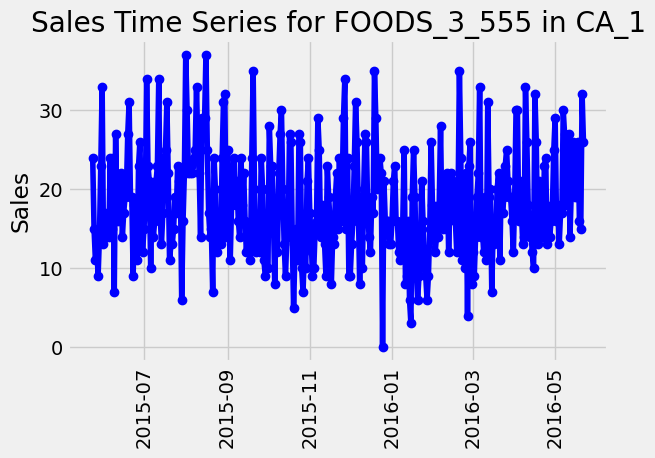

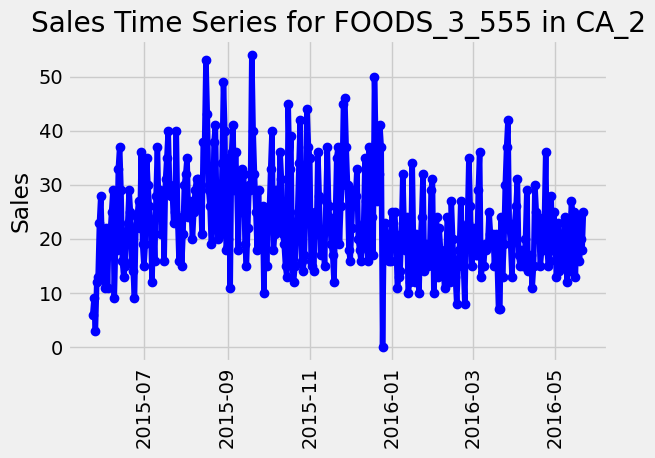

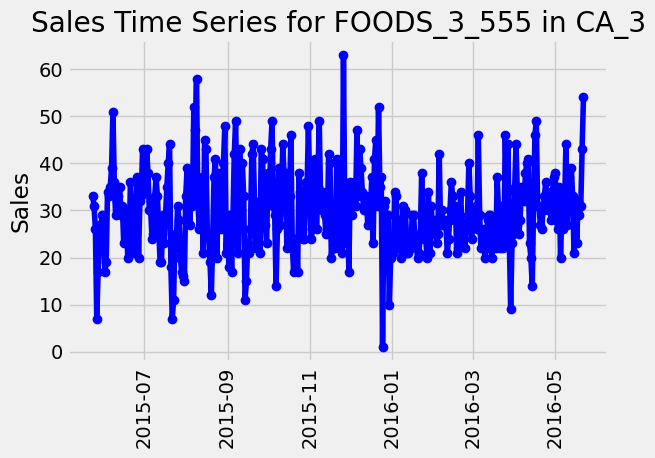

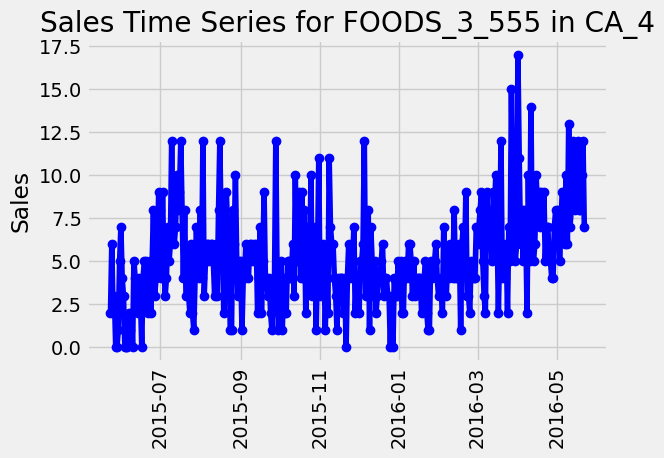

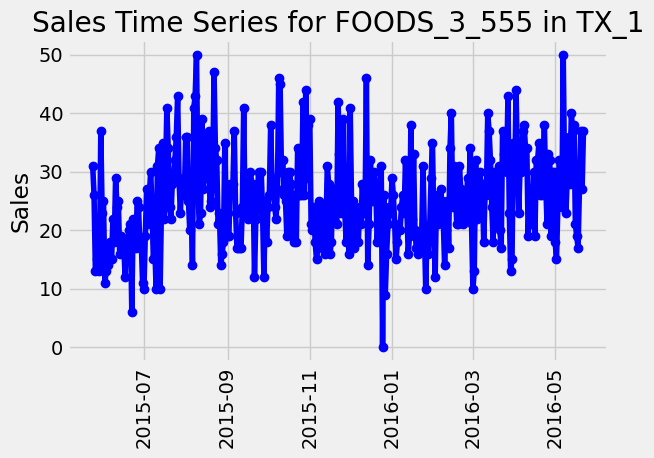

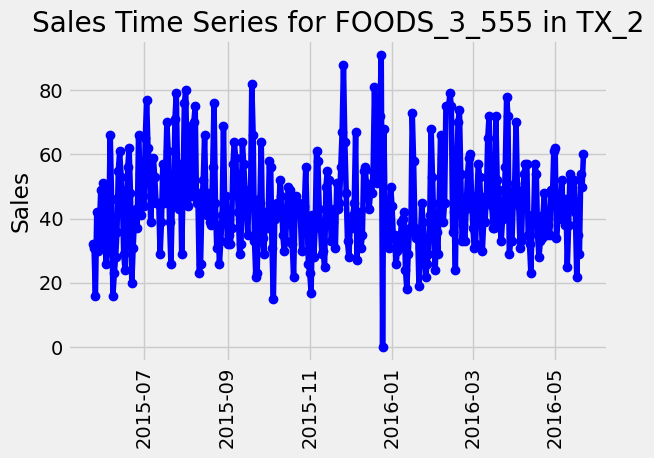

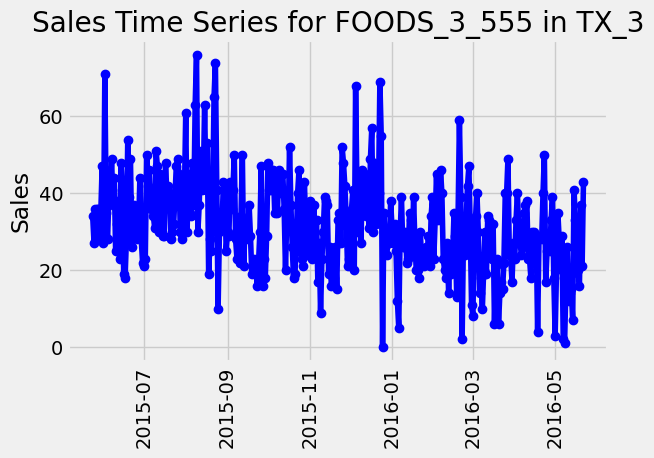

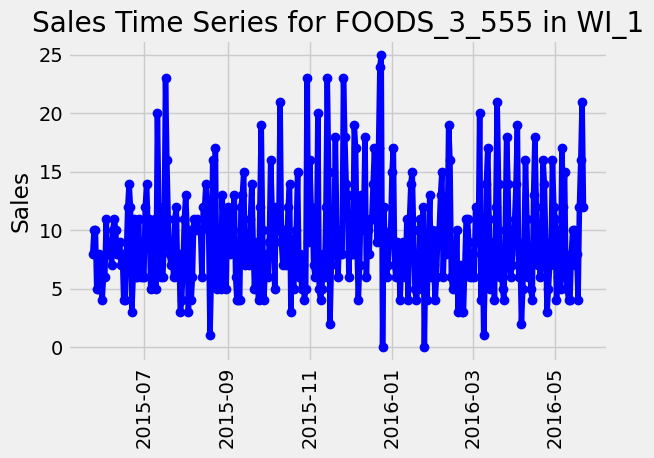

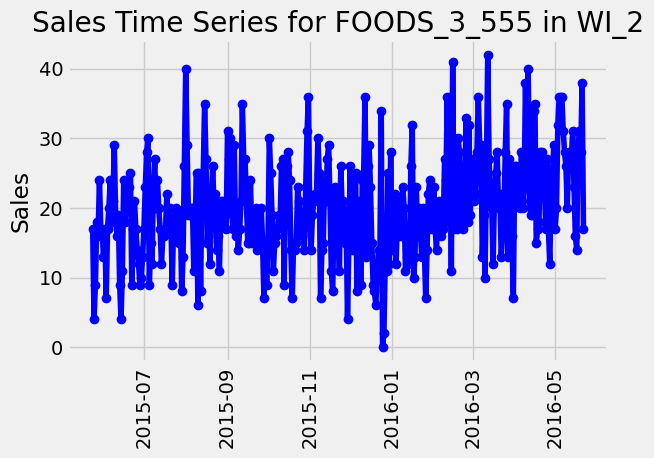

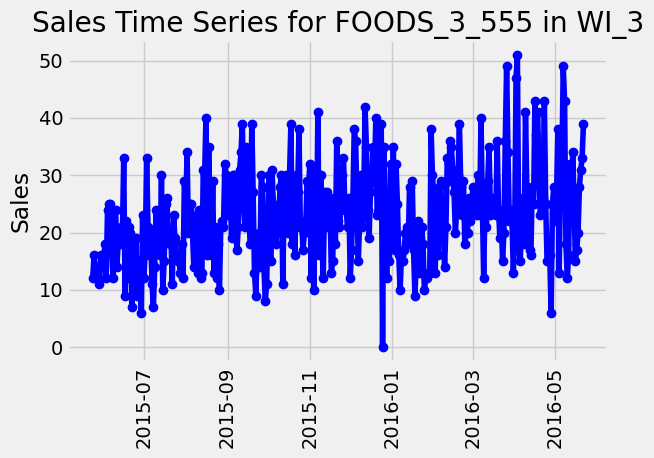

In [14]:

product_id = 'FOODS_3_555'
#region1 = 'CA'   # according to requirements the region 1 and region2 parameter was changed to plot the appropriate graphs
#region2 = 'WI'

for i in stores_list:

    region1_data = data_long[(data_long['item_id'] == product_id) & (data_long['store_id'] == i)]

    region1_time_series = region1_data.groupby('date')['sales'].sum().reset_index()

# Plot for Region 1
    plt.plot(region1_time_series['date'].tail(365), region1_time_series['sales'].tail(365), marker='o', color='b', label=f'Region {i}')
    plt.title(f'Sales Time Series for {product_id} in {i}')
    plt.ylabel('Sales')

# Rotate x-axis labels for readability
    plt.xticks(rotation=90)

# Adjust layout for better spacing
    plt.tight_layout()

# Save the plots to a file
    plt.savefig(f'{i}.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plots
    plt.show()

In [15]:
# Code to assess seasonality during Christmas

In [16]:
# Define the Christmas period
start_date = '2012-12-18'
end_date = '2013-01-03'

filtered_data = data_long[(data_long['date'] >= start_date) & (data_long['date'] <= end_date)]

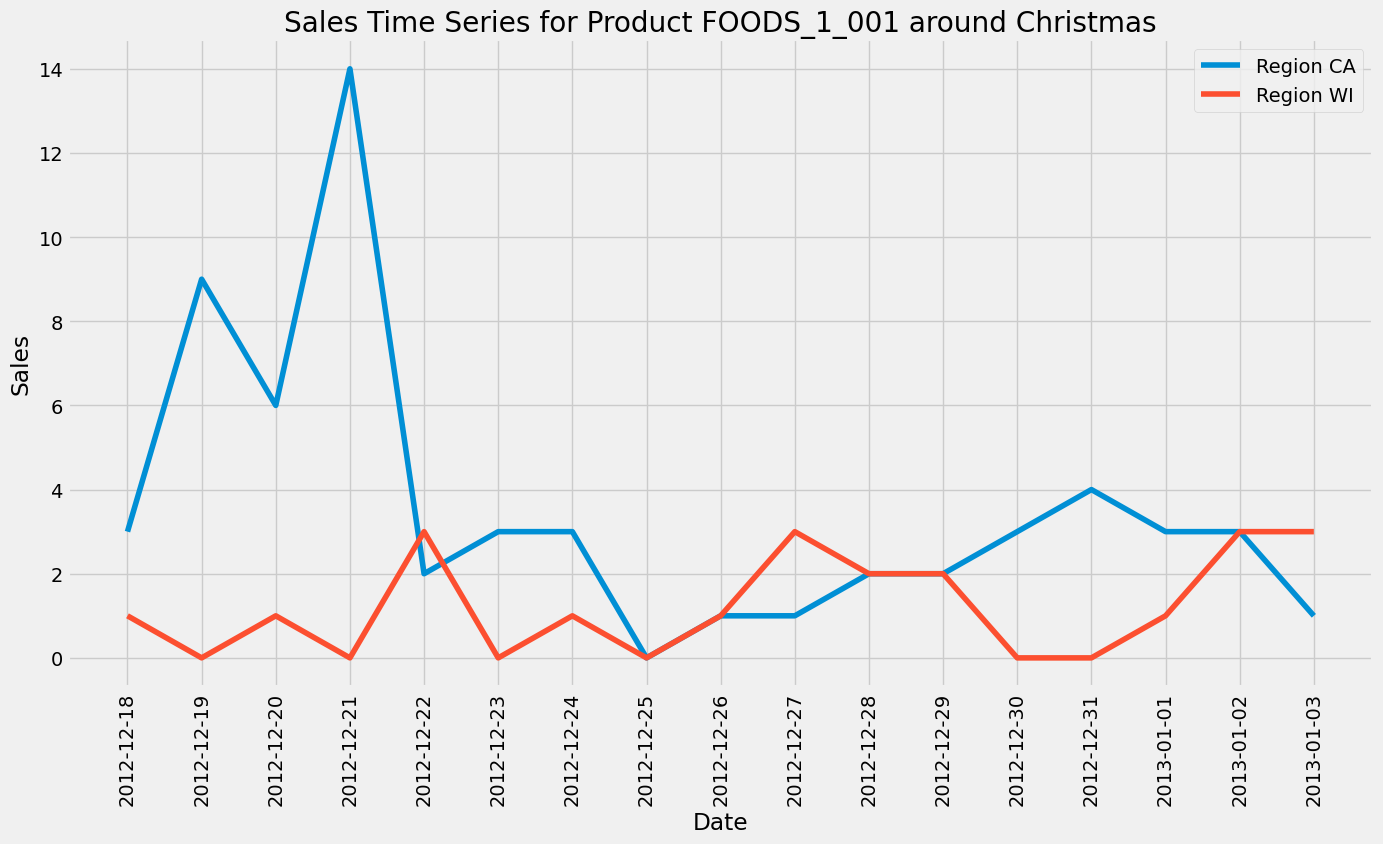

In [17]:
# plotting the graphs for the product and particular regions during the Christmas period
product_id = 'FOODS_1_001'
region1 = 'CA'
region2 = 'WI'

# Filter the dataset for the specific product and regions
region1_data = filtered_data[(filtered_data['item_id'] == product_id) & (filtered_data['state_id'] == region1)]
region2_data = filtered_data[(filtered_data['item_id'] == product_id) & (filtered_data['state_id'] == region2)]

# Group the data by date and sum the sales for each region
region1_time_series = region1_data.groupby('date')['sales'].sum().reset_index()
region2_time_series = region2_data.groupby('date')['sales'].sum().reset_index()

# Plot the sales time series for both regions
plt.figure(figsize=(15, 8))
plt.plot(region1_time_series['date'], region1_time_series['sales'], label=f'Region {region1}')
plt.plot(region2_time_series['date'], region2_time_series['sales'], label=f'Region {region2}')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Sales Time Series for Product {product_id} around Christmas')
plt.legend()
plt.grid(True)
plt.xticks(rotation = 90)

# Format date labels on x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())
# Save the plot to a file
plt.savefig('FOODS_1_001_CA_WI_christmas.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()